This notebook uses LDA to extract topics from the curriculum texts and uses pyLDAvis for visualization.

LDA considers each document as a collection of topics in a certain proportion. It rearranges the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.


### Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('en_core_web_lg')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from pprint import pprint

In [6]:
df = pd.read_excel('ac_curriculum_2018.xlsx', index_col=0)

/usr/local/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/usr/local/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/usr/local/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/usr/local/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/usr/local/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/usr/local/lib/python3.7/site-packages/defusedxml/ElementTre

In [7]:
df['text'] = df['text'].astype(str)
df['text_parsed'] = list(nlp.pipe(df['text']))

In [8]:
# remove stopwords and punctuations
df['tokenized'] = df['text_parsed'].apply(lambda doc: [str(t) for t in doc if not t.is_punct and not t.is_stop])

In [9]:
# with nouns
df['text_nouns'] = df['text_parsed'].apply(lambda doc: [str(t) for t in doc if t.pos_ in ['NOUN', 'PROPN']])

In [10]:
data_words = list(df['tokenized'])

In [11]:
data_nouns = list(df['text_nouns'])

### Create bigrams and trigram models

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['tokenized'], min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['tokenized']], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[df['tokenized'][0]]])

### Remove Stopwords, Make Bigrams and Lemmatize

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Form Bigrams
data_nouns_bigrams = make_bigrams(data_nouns)
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_nouns_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['year', 'student', 'peers_teacher', 'adult', 'student', 'class', 'student', 'variety', 'text', 'enjoyment', 'text', 'purpose', 'text', 'text', 'picture', 'book', 'type', 'story', 'verse', 'poetry', 'film', 'text', 'performance', 'read', 'storytelling', 'range', 'text', 'nature', 'literature', 'student', 'range', 'text', 'representation', 'statement', 'performance', 'recount', 'poetry']]


### Create the Dictionary and Corpus needed for Topic Modeling

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

In [16]:
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 4), (20, 7), (21, 1), (22, 1), (23, 1), (24, 1)]]


In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('adult', 1),
  ('book', 1),
  ('class', 1),
  ('enjoyment', 1),
  ('film', 1),
  ('literature', 1),
  ('nature', 1),
  ('peers_teacher', 1),
  ('performance', 2),
  ('picture', 1),
  ('poetry', 2),
  ('purpose', 1),
  ('range', 2),
  ('read', 1),
  ('recount', 1),
  ('representation', 1),
  ('statement', 1),
  ('story', 1),
  ('storytelling', 1),
  ('student', 4),
  ('text', 7),
  ('type', 1),
  ('variety', 1),
  ('verse', 1),
  ('year', 1)]]

### Building the Topic Model

alpha affects sparsity of the topics. According to the Gensim docs, defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. 
update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [41]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=50,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='asymmetric',
                                           per_word_topics=True,
                                           )

In [42]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.105*"text" + 0.052*"student" + 0.048*"range" + 0.027*"type" + '
  '0.026*"year" + 0.020*"information" + 0.020*"performance" + 0.019*"medium" + '
  '0.017*"face" + 0.016*"variety"'),
 (1,
  '0.059*"science" + 0.058*"strand" + 0.044*"content" + 0.038*"student" + '
  '0.034*"year" + 0.032*"system" + 0.026*"understand" + 0.024*"pattern" + '
  '0.022*"observation" + 0.019*"curriculum"'),
 (2,
  '0.083*"activity" + 0.080*"movement" + 0.064*"student" + 0.050*"skill" + '
  '0.034*"health" + 0.025*"content" + 0.022*"knowledge" + 0.022*"safety" + '
  '0.022*"curriculum" + 0.021*"relationship"'),
 (3,
  '0.074*"content" + 0.044*"problem" + 0.038*"proficiency" + 0.029*"number" + '
  '0.026*"mathematic" + 0.024*"understanding" + 0.023*"fluency" + '
  '0.023*"strand" + 0.019*"learn" + 0.018*"fractions_decimal"'),
 (4,
  '0.060*"content" + 0.042*"number" + 0.038*"proficiency" + 0.029*"problem" + '
  '0.026*"fluency" + 0.026*"mathematic" + 0.024*"reason" + 0.021*"language" + '
  '0.019*"unde

### Compute Model Perplexity and Coherence Score

Perplexity metric measures how probable some new unseen data is given the model that was learned earlier. That is to say, how well does the model represent or reproduce the statistics of the held-out data.

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

In [43]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.110172832622449

Coherence Score:  0.8708681658855433


### Visualize the topics-keywords
Examine the produced topics and the associated keywords. 

Each bubble represents a topic. The larger the bubble, the more prevalent is that topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

In [44]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.253924  0.051429       1        1  21.268322
1      0.066184 -0.221601       2        1  15.682663
3      0.196149  0.122102       3        1  15.207397
2     -0.032089 -0.005739       4        1  14.411651
6      0.030194 -0.217990       5        1  11.939601
5     -0.219398  0.089487       6        1  10.240904
4      0.200345  0.146536       7        1  10.232541
7      0.012540  0.035775       8        1   1.016924, topic_info=    Category        Freq           Term       Total  loglift  logprob
20   Default  106.000000           text  106.000000  30.0000  30.0000
119  Default   39.000000       activity   39.000000  29.0000  29.0000
132  Default   38.000000       movement   38.000000  28.0000  28.0000
349  Default   42.000000        science   42.000000  27.0000  27.0000
167  Default   35.000000         system   35.000000  26.0000  26.0000
231  Default   54.000000         strand   54.000000  25.0000  25.0000
31   Default   94.000000        content   94.000000  24.0000  24.0000
19   Default  108.000000        student  108.000000  23.0000  23.0000
181  Default   30.000000    proficiency   30.000000  22.0000  22.0000
187  Default   30.000000        problem   30.000000  21.0000  21.0000
45   Default   28.000000         number   28.000000  20.0000  20.0000
12   Default   52.000000          range   52.000000  19.0000  19.0000
138  Default   36.000000          skill   36.000000  18.0000  18.0000
127  Default   16.000000         health   16.000000  17.0000  17.0000
222  Default   19.000000     mathematic   19.000000  16.0000  16.0000
219  Default   18.000000        fluency   18.000000  15.0000  15.0000
8    Default   20.000000    performance   20.000000  14.0000  14.0000
80   Default   13.000000         medium   13.000000  13.0000  13.0000
10   Default   14.000000         poetry   14.000000  12.0000  12.0000
21   Default   25.000000           type   25.000000  11.0000  11.0000
228  Default   14.000000         reason   14.000000  10.0000  10.0000
144  Default   19.000000         change   19.000000   9.0000   9.0000
373  Default   11.000000         energy   11.000000   8.0000   8.0000
140  Default   27.000000  understanding   27.000000   7.0000   7.0000
24   Default   54.000000           year   54.000000   6.0000   6.0000
345  Default   10.000000    observation   10.000000   5.0000   5.0000
22   Default   20.000000        variety   20.000000   4.0000   4.0000
137  Default   10.000000         safety   10.000000   3.0000   3.0000
366  Default   11.000000         matter   11.000000   2.0000   2.0000
323  Default   13.000000          scale   13.000000   1.0000   1.0000
..       ...         ...            ...         ...      ...      ...
330   Topic8    0.384548   independence    1.162554   3.4821  -4.3367
329   Topic8    0.384521        formula    1.162607   3.4820  -4.3367
338   Topic8    0.384487       unknowns    1.162668   3.4818  -4.3368
334   Topic8    0.384412           step    1.162767   3.4815  -4.3370
332   Topic8    0.384181        lengths    1.163159   3.4806  -4.3376
335   Topic8    0.384117   substitution    1.163314   3.4803  -4.3378
308   Topic8    0.384739     congruence    2.024379   2.9279  -4.3362
326   Topic8    0.367782   trigonometry    2.145172   2.8249  -4.3812
324   Topic8    0.376616     similarity    3.020227   2.5065  -4.3575
16    Topic8    0.269629      statement    2.201772   2.4884  -4.6917
321   Topic8    0.361391          graph    3.109544   2.4361  -4.3988
325   Topic8    0.369031        surface    3.986885   2.2085  -4.3778
161   Topic8    0.381253       relation    4.887972   2.0373  -4.3453
303   Topic8    0.227448         volume    4.012105   1.7182  -4.8618
43    Topic8    0.373194       interest    7.316871   1.6125  -4.3666
257   Topic8    0.135974       fraction    4.132211   1.1743  -5.3763
292   Topic8    0.138938     expression    4.316315   1.1

### Find optimal number of topics

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics, 
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=1, 
                                                        limit=30, 
                                                        step=1)

In [25]:
x = range(1, 30, 5)
print (x)

range(1, 30, 5)


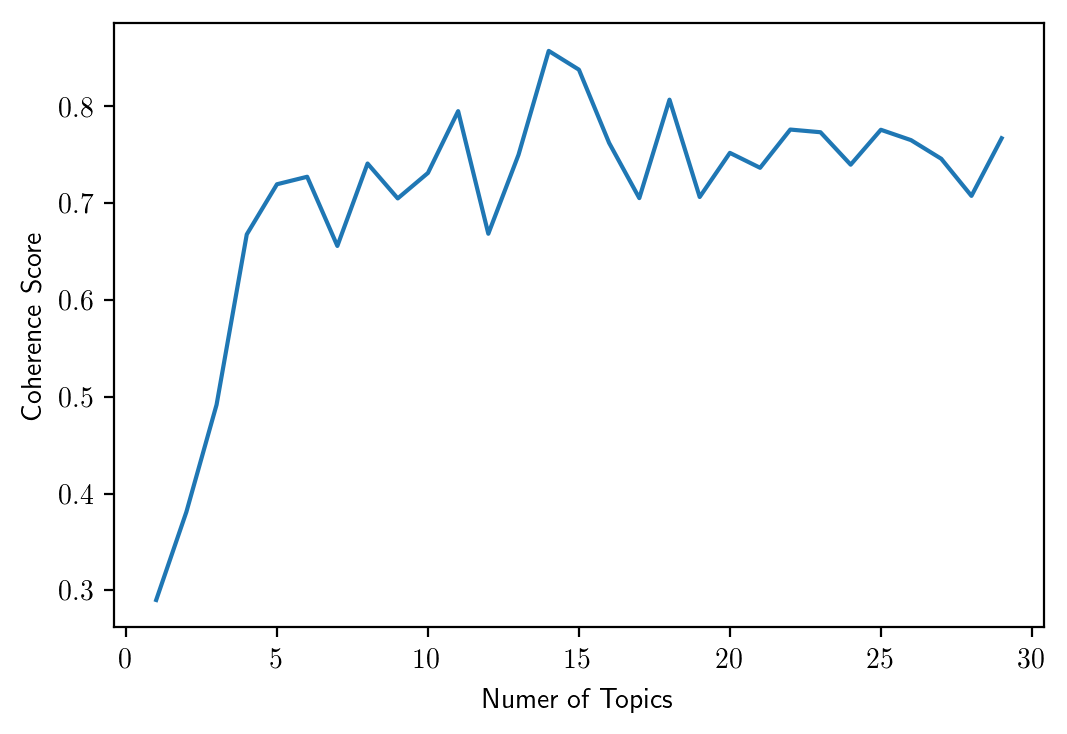

<Figure size 432x288 with 0 Axes>

In [26]:
# Show graph
start=1; limit=30; step=1;
x = range(start, limit, step)

from matplotlib import rc
rc('text', usetex=True)

plt.figure(dpi=200)
plt.plot(x, coherence_values)
plt.xlabel("Numer of Topics")
plt.ylabel("Coherence Score")
plt.show()
plt.savefig('coherence')

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.29
Num Topics = 2  has Coherence Value of 0.381
Num Topics = 3  has Coherence Value of 0.4918
Num Topics = 4  has Coherence Value of 0.6678
Num Topics = 5  has Coherence Value of 0.7196
Num Topics = 6  has Coherence Value of 0.7274
Num Topics = 7  has Coherence Value of 0.6559
Num Topics = 8  has Coherence Value of 0.741
Num Topics = 9  has Coherence Value of 0.705
Num Topics = 10  has Coherence Value of 0.7313
Num Topics = 11  has Coherence Value of 0.7952
Num Topics = 12  has Coherence Value of 0.6685
Num Topics = 13  has Coherence Value of 0.7501
Num Topics = 14  has Coherence Value of 0.8574
Num Topics = 15  has Coherence Value of 0.838
Num Topics = 16  has Coherence Value of 0.7623
Num Topics = 17  has Coherence Value of 0.7053
Num Topics = 18  has Coherence Value of 0.807
Num Topics = 19  has Coherence Value of 0.7065
Num Topics = 20  has Coherence Value of 0.752
Num Topics = 21  has Coherence Value of 0.7366
Num Topics = 22  has Coherence

In [28]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

### Define dominant topics in each sentence

In [29]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [30]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_nouns)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9768,"text, student, poetry, range, performance, var...","[Foundation, year, students, peers, teachers, ..."
1,1,3.0,0.9733,"text, student, poetry, range, performance, var...","[Year, students, peers, teachers, adults, stud..."
2,2,3.0,0.9877,"text, student, poetry, range, performance, var...","[Year, students, peers, teachers, students, cl..."
3,3,3.0,0.9895,"text, student, poetry, range, performance, var...","[Years, students, contexts, range, contexts, a..."
4,4,3.0,0.9896,"text, student, poetry, range, performance, var...","[Years, students, contexts, range, contexts, a..."


In [31]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
#df_dominant_topics

### Frequency Distribution of Word Counts in Documents

In [32]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9921,"activity, movement, student, skill, health, year, curriculum, range, relationship, safety","[Year, curriculum, knowledge, understanding, skills, outcomes, classroom, leisure, movement, sit..."
1,1.0,0.9883,"science, strand, system, content, student, year, understand, change, scale, pattern","[science, inquiry, skills, science, endeavour, strands, year, band, planning, schools, teachers,..."
2,2.0,0.9788,"content, skill, strand, learn, student, knowledge, use, understanding, work, play","[content, year, level, strands, skills, learning, work, career, life, design, strand, turn, stra..."
3,3.0,0.9896,"text, student, poetry, range, performance, variety, book, type, year, class","[Years, students, contexts, range, contexts, areas, curriculum, peers, teachers, classes, school..."
4,4.0,0.9885,"content, proficiency, problem, number, mathematic, fluency, understanding, reason, language, datum","[proficiency, understanding, fluency, problem, reasoning, part, mathematics, content, content, s..."
5,6.0,0.9905,"text, student, range, type, year, medium, information, face, performance, structure","[Years, students, peers, teachers, individuals, groups, community, members, range, face, face, e..."


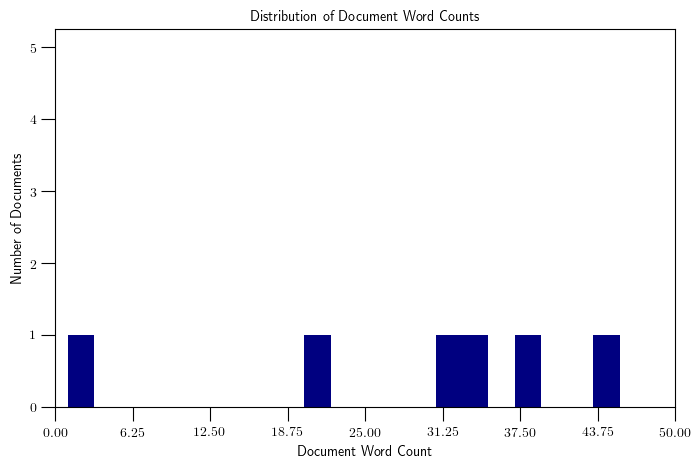

In [33]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

plt.figure(figsize=(8,5), dpi=100)
plt.hist(doc_lens, bins = 50, color='navy')
plt.gca().set(xlim=(0, 50), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=10)
plt.xticks(np.linspace(0,50,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))
plt.show()


### Word Clouds of Top N Keywords in Each Topic

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/qiusuwang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


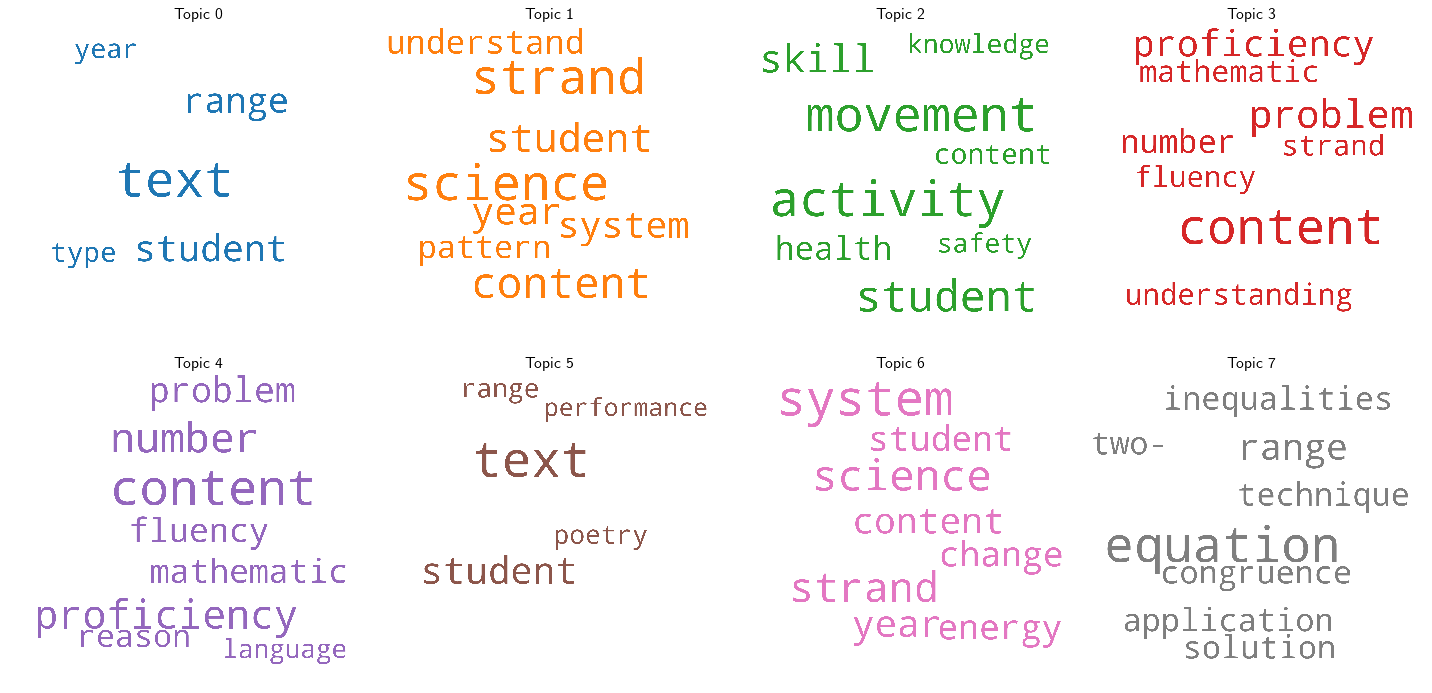

In [45]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
rc('text', usetex=True)
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2000,
                  height=1800,
                  max_words=8,
                  colormap='tab10',
                  min_font_size = 150,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [46]:
plt.savefig('topic.png')

<Figure size 432x288 with 0 Axes>

### t-SNE Clustering Chart

In [39]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [40]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points 
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=500, plot_height=400)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.000s...
[t-SNE] Computed neighbors for 42 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 0.359498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.056320
[t-SNE] KL divergence after 1000 iterations: 0.344735


Loading BokehJS ...